# Jupyter notebook to analyze steel stress calculations

This notebook is created and originally uploaded on GitHub by Anton van der Esch and contains the calculations of the paper "Calculation of steel stresses in cracked reinforced rectangular concrete elements loaded in bending".
<br> <br>
**Name | Orcid-ID** <br>
Anton van der Esch* | 0000-0002-3229-5267 <br>
Rob Wolfs | 0000-0001-7897-433X <br>
Simon Wijte | 0000-0003-4869-4948
<br> <br>
Eindhoven University of Technology <br>
5612 AZ Eindhoven <br>
The Netherlands
<br> <br>
*Corresponding author

## Warning

When using this notebook, you should cite, BESIDES THIS NOTEBOOK, also the following paper "Crack Monitoring in Reinforced Concrete Beams by Distributed Optical Fiber Sensors" since this Notebook uses data from that paper.
<br> <br>
Use the following citation:
<br>
Carlos G. Berrocal, Ignasi Fernandez & Rasmus Rempling (2021) Crack
monitoring in reinforced concrete beams by distributed optical fiber sensors, Structure and
Infrastructure Engineering, 17:1, 124-139, DOI: 10.1080/15732479.2020.1731558



## Introduction

This notebook provides the code for the paper "The development of a method for the estimation of steel stresses in cracked reinforced concrete elements loaded in bending". It has been divided into several parts: <br>
1) Import packages <br>
2) Figure settings <br>
3) Import and / or create data files <br>
4) Parameters <br>
5) Throughput <br>
6) Calculation of steel stress <br>
7) Force and time plots <br>
8) Evaluation of the strains and stresses

## 1 - Import packages

In [1]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
from pandas import read_csv
import pandas as pd
import scipy.integrate as integrate
import scipy.special as special
import random
import os

from scipy.optimize import fsolve
from scipy.interpolate import interp1d
from scipy.integrate import quad, trapezoid, nquad, dblquad
from time import sleep
from tqdm import tqdm

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

## 2 - Figure settings

In [2]:
cm = 1/2.54;
figsize = [7*cm,5*cm];

plt.rcParams.update({'mathtext.fontset': 'cm'})
plt.rcParams.update({'font.family': 'STIXGeneral'})
plt.rcParams.update({'axes.labelsize': 11})
plt.rcParams.update({'axes.titlesize': 12})

import matplotlib.ticker as mticker
dpisize = 600;

## 3 - Import files

In [3]:
#dat_beams = pd.read_csv(r'https://github.com/iavdesch/Research/tree/main/SynerCrete_23/Data_full_combined.csv?raw=true',\
#                   sep=',',lineterminator='\n');

dat_beams = pd.read_csv('https://github.com/iavdesch/Research/blob/main/SynerCrete_23/Data_full_combined.csv?raw=true',\
                       sep=',')

crack_width_beam_1 = pd.read_csv('https://github.com/iavdesch/Research/blob/main/SynerCrete_23/Crack_width_time_1.csv?raw=true',\
                       sep=',')
crack_width_beam_2 = pd.read_csv('https://github.com/iavdesch/Research/blob/main/SynerCrete_23/Crack_width_time_2.csv?raw=true',\
                       sep=',')

### Interpolate for the forces

The sampling rate of the DOFs (5Hz) differs from the sampling rate of the DIC (0.2Hz). The forcing in the experiments was originally measured at the sampling rate of the DIC. To estimate the force corresponding to the time instances of the DOFs linear interpolation is applied.

In [4]:
interpl_1 = interp1d(dat_beams["Time_DIC_1"],dat_beams["Force_DIC_1"]);
Force_DOFS_1 = interpl_1(dat_beams["Time_DOFS_1"]);

interpl_2 = interp1d(dat_beams["Time_DIC_2"],dat_beams["Force_DIC_2"]);
Force_DOFS_2 = interpl_2(dat_beams["Time_DOFS_2"]);

The resulting dataframe reads:

In [5]:
dat_beams = pd.concat([dat_beams.reset_index(drop=True),\
                      pd.DataFrame(Force_DOFS_1).reset_index(drop=True),\
                      pd.DataFrame(Force_DOFS_2).reset_index(drop=True)],axis=1);

dat_beams.columns = ["Time_DIC_1","Force_DIC_1","Time_DOFS_1",\
                     "Time_DIC_2","Force_DIC_2","Time_DOFS_2",\
                     "eps_c1_b1", "eps_c2_b1", "eps_c3_b1", "eps_c4_b1", "eps_c5_b1", "eps_c6_b1",\
                     "eps_c1_b2", "eps_c2_b2", "eps_c3_b2", "eps_c4_b2", "eps_c5_b2", "eps_c6_b2",\
                     "Force_DOFS_1","Force_DOFS_2"];

Change the time scale from minutes to seconds. Sicne only beams (1) and (2) are considered; the conversion is made only for those beams.

In [6]:
crack_width_beam_1["Time"] = crack_width_beam_1["Time"]*60;
crack_width_beam_2["Time"] = crack_width_beam_2["Time"]*60;

### Time, forces and moments when crack $w=0.05$ mm

In the paper you can read that the comparison between the developed method and methods of v.d. Schrier and the Interpolation method started from the onset where the considered crack width $w$ of crack $(4)$ is at a minimum of 0.05mm. The corresponding values of $w$, $t$, $F$ and the corresponding moment $M_{\mathrm{ext}}$.

In [7]:
print("Crack width closest to 0.05mm:",np.round(crack_width_beam_1["w"][7],3),"mm.")
print("Time closest to 0.05mm:",np.round(crack_width_beam_1["Time"][7],3),"s.")

interpl_1 = interp1d(dat_beams["Time_DIC_1"],dat_beams["Force_DIC_1"]);
Force_first_crack_beam_1 = interpl_1(crack_width_beam_1["Time"][7]);
print("Force when crack width is closest to 0.05mm:",np.round(Force_first_crack_beam_1,3),"kN")

M_crack_1 = 0.25*Force_first_crack_beam_1*0.8*(1-((0.053-0.05)/0.4))
print("Bending moment when first crack is closest to 0.05mm:",round(M_crack_1,3),"kNm")

print("\n");

print("Crack width closest to 0.05mm:",np.round(crack_width_beam_2["w"][8],3),"mm")
print("Time closest to 0.05mm:",np.round(crack_width_beam_2["Time"][8]),3);

interpl_2 = interp1d(dat_beams["Time_DIC_2"],dat_beams["Force_DIC_2"]);
Force_first_crack_beam_2 = interpl_2(crack_width_beam_2["Time"][8]);
print("Force when crack width is closest to 0.05mm:", np.round(Force_first_crack_beam_2,3),"kN");

M_crack_2 = 0.25*Force_first_crack_beam_2*0.8*(1-((0.089-0.05)/0.4))
print("Bending moment when first crack is closest to 0.05mm:",np.round(M_crack_2,3),"kNm")

Crack width closest to 0.05mm: 0.055 mm.
Time closest to 0.05mm: 164.967 s.
Force when crack width is closest to 0.05mm: 12.696 kN
Bending moment when first crack is closest to 0.05mm: 2.52 kNm


Crack width closest to 0.05mm: 0.052 mm
Time closest to 0.05mm: 224.0 3
Force when crack width is closest to 0.05mm: 15.594 kN
Bending moment when first crack is closest to 0.05mm: 2.815 kNm


### Interpolate for the crack widths according to the sampling rate of the DOFs

In [8]:
timeipl_1 = interp1d(crack_width_beam_1["Time"],crack_width_beam_1["w"]);
w_DOFS_1 = timeipl_1(dat_beams["Time_DOFS_1"].iloc[0:6200]);

timeipl_2 = interp1d(crack_width_beam_2["Time"],crack_width_beam_2["w"]);
w_DOFS_2 = timeipl_2(dat_beams["Time_DOFS_2"].iloc[0:6200]);

In [9]:
datframe_crack_width_1 = pd.concat([dat_beams["Time_DOFS_1"].reset_index(drop=True),\
                      pd.DataFrame(w_DOFS_1).reset_index(drop=True)],axis=1);
datframe_crack_width_1.columns = ["Time_DOFS_1","w"];

datframe_crack_width_2 = pd.concat([dat_beams["Time_DOFS_2"].reset_index(drop=True),\
                      pd.DataFrame(w_DOFS_2).reset_index(drop=True)],axis=1);
datframe_crack_width_2.columns = ["Time_DOFS_2","w"];

### Plot the crack widths according to the applied force based on the sampling rate of the DOFs

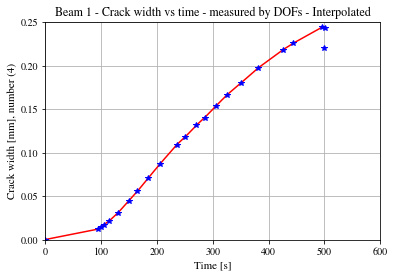

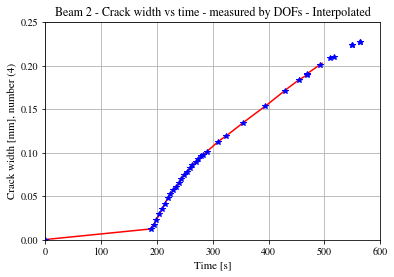

In [10]:
plt.figure();
plt.plot(datframe_crack_width_1["Time_DOFS_1"],datframe_crack_width_1["w"],'r',label="Time DOFs");
plt.plot(crack_width_beam_1["Time"],crack_width_beam_1["w"],"*b",label="Time DICs");
plt.xlabel("Time [s]");
plt.ylabel("Crack width [mm], number (4)");
plt.title("Beam 1 - Crack width vs time - measured by DOFs - Interpolated");
plt.xlim(0,600);
plt.ylim(0,0.25);
plt.grid();

plt.figure();
plt.plot(datframe_crack_width_2["Time_DOFS_2"],datframe_crack_width_2["w"],'r',label="Time DOFs");
plt.plot(crack_width_beam_2["Time"],crack_width_beam_2["w"],"*b",label="Time DICs");
plt.xlabel("Time [s]");
plt.ylabel("Crack width [mm], number (4)");
plt.title("Beam 2 - Crack width vs time - measured by DOFs - Interpolated");
plt.xlim(0,600);
plt.ylim(0,0.25);
plt.grid();

### Crack spacing according to Carlos et al.

The table below presents the location of the crack widths. Each column represent a crack; each row represents the beam. So, the amount of cracks measured for each beam is $5$ or $6$.

In [11]:
crack_loc_beams = pd.read_csv(r'C:\Users\20210065\surfdrive\Documents\60_Publications\Synercrete_23\Calculations\Data\Received\OneDrive_1_13-10-2022\Crack_positions_dofs.csv',\
                   sep=',',header=None);

print(round(crack_loc_beams,3));

         0        1        2        3        4        5        6
0  155.533  259.533  354.433  453.233  555.933  672.333      NaN
1  155.625  268.725  362.975  489.075  552.125  666.475      NaN
2  114.864  224.064  335.864  450.914  507.464  582.864  658.964
3  187.133  288.533  391.233  454.283  536.833  634.983      NaN
4  186.807  254.407  331.107  422.107  516.357  595.657  729.557
5  156.879  250.479  306.379  376.579  479.929  550.779  659.979


## 4 - Parameters for the analysis

In [12]:
# Concrete properties
f_cmcube = 61; #MPa; mean concrete cube compression strength
f_ctm = 4; #MPa; mean concrete tensile strength
Ec = 30000; #N/mm2; Youngs modulus of concrete

# Reinforcement properties
nbars = 2; #Number of bars
phi = 10; #mm; diameter of reinforcement
Es = 200000; #N/mm2; Youngs modulus of the reinforcement
As = nbars*(1/4)*np.pi*phi**2; #N/mm2; Area of the reinforcement
fy = 518; #N/mm2; Yield strength of the reinforcement

# Geometry
b = 100; #mm; width of the element
h = 150; #mm; height of the element
d = 120; #mm; working height of the element
L = 800/1000; #mm; Span of the element between the supports
c= 20; #mm; concrete cover

In [13]:
# Average cylindrical compression strength
f_cm = 0.8513*f_cmcube + 2.995; #MPa; mean cylindrical compression strength, calculated from the mean cubic strength

# Fracture energy
Gf1 = 73*f_cm**(0.18)/1000; #N/mm; fracture energy according to mode 1;

# Compression curve according to fib Model Code 2010
eps_c1 = 0.0026; # Strain at maximum compression stress
eps_lim = 0.0036; # Maximum allowable strain
k = 1.71; # Ratio of Ec,i/Ec,1: tangent short-term youngs modulus of concrete / secant modulus

# Input for Hordijk model
cbw_1 = 101; #mm; crack bandwidth beam 1; chosen to be srm close to crack 4; = mean distance of crack 3-4 and 4-5
cbw_2 = 86; #mm; crack bandwidth beam 1; chosen to be srm close to crack 4; = mean distance of crack 3-4 and 4-5
c1 = 3; # Shape of the Hordijk Tension Softening curve
c2 = 6.93; # Shape of the Hordijk Tension Softening curve

ultstrain_1 = (5.136*Gf1/f_ctm) * (1/cbw_1);
ultstrain_2 = (5.136*Gf1/f_ctm) * (1/cbw_2);

# Analysis of the results
nend_1 = 6200; nend_2 = 7000; # Starting and ending points of the analysis
nstart_1 = 2053; nstart_2 = 2800; # Starting and ending points of the analysis
npoints_1 = nend_1-nstart_1; npoints_2 = nend_2-nstart_2;

## 5 - Throughput

### Crack widths according to Berrocal et al.

Since the paper "Calculation of steel stresses in cracked reinforced rectangular concrete elements loaded in bending" considers cracking; the cracking moment is calculated according to the paper which provided the data for this study.

In [14]:
# According to paper:
M_crack_1_berrocal = 0.25*4.78*0.8*(1-((0.053-0.05)/0.4));
print("Cracking moment according to Berrocal:",np.round(M_crack_1_berrocal,3),"kNm");

M_crack_2_berrocal = 0.25*5.26*0.8*(1-((0.089-0.05)/0.4))
print("Cracking moment according to Berrocal:",np.round(M_crack_2_berrocal,3),"kNm");

Cracking moment according to Berrocal: 0.949 kNm
Cracking moment according to Berrocal: 0.949 kNm


### Cracking moment according *fib* Model Code 2010

In [15]:
# Cracking moment
a_fl = (0.06*b**0.7)/(1+0.06*b**0.7);
f_ctm_fl =(1/a_fl)*f_ctm; #MPa
Mcr = (1/6)*b*h**2 * f_ctm_fl; #Nmm

print("Cracking moment according to fib Model Code 2010: ",round(Mcr/(10**6),1),"kNm");

Cracking moment according to fib Model Code 2010:  2.5 kNm


### Ultimate resistance

In [16]:
# Ultimate resistance of the bending moment
z = d-(7/18)*As*fy/((3/4)*f_cm*b); # Internal lever arm; mm
Mr = As*fy*z; # Ultimate bending moment resistance; Nmm

print("Ultimate moment resistance ",round(Mr/(10**6),1),"kNm");

Ultimate moment resistance  9.1 kNm


## 6 - Calculation of steel stresses

### Assuming a triangular compression zone: Method v.d. Schrier

In [17]:
ae = Es/Ec; rho = As/(b*d);
xc_schrier_temp = d*(-ae*rho + ( (ae*rho)**2 + 2*ae*rho )**(1/2));
print("Height of the compression zone equals",round(xc_schrier_temp,3), "mm");

Height of the compression zone equals 40.743 mm


Below the function to calculate the height of the concrete compression zone and the corresponding strain at the top of the cross section, according to the Schrier method.

In [18]:
def schrier_org(Mext):
    
    ae = Es/Ec;
    rho = As/(b*d);
    
    xc_schrier = d*(-ae*rho + ( (ae*rho)**2 + 2*ae*rho )**(1/2));
    z = d-xc_schrier/3;
    
    Fs = Mext/z;
    sigs = Fs/As;
    
    eps_c_schrier = 2*Mext/( Ec*b*xc_schrier*(d-xc_schrier/3));
    
    return xc_schrier, sigs, eps_c_schrier

### Assuming linear interpolation between $M_{\mathrm{ext}}$ and $M_{\mathrm{R}}$

Below the function to calculate the height of the concrete compression zone and the corresponding strain at the top of the cross section, according to the Interpolation method.

In [19]:
def interpol(Mext):
    
    z = d-(7/18)*As*fy/((3/4)*f_cm*b);
    
    Mr = As*fy*z;
    
    sigs_inpl = Mext/Mr * fy;
    eps_s = sigs_inpl / Es;
    
    xc_inpl = As*fy/((3/4)*f_cm*b);
    
    eps_c_inpl = eps_s*xc_inpl/(d-(c+phi/2));
    
    return xc_inpl, sigs_inpl, eps_c_inpl

### Results Response 2000

In [20]:
dat_response_2000 = pd.read_csv(r'C:\Users\20210065\surfdrive\Documents\60_Publications\Synercrete_23\Calculations\Data\Response_2000_output.csv',\
                   sep=',');

### Steel stress using nonlinear compression and Hordijk tension softening

Below the function to calculate the height of the concrete compression zone and the corresponding strain at the top of the cross section, according to the Developed method as described in the paper.

#### Setting up the equilibrium equations and solve for $x_{\mathrm{c}}$ and $\epsilon_{\mathrm{ext}}$

Below the equation to address case 1: at some point in the cross section, the strain is smaller than the ultimate strain.

In [21]:
def eqset_1(p,Mext,ultstrain):
    
    eps_c,xc = p;

    # Tension part 1
    #=============================================================
    xt1 = f_ctm*xc/(eps_c*Ec);
    Fct1 = xt1*b*f_ctm/2;
   
    eps_b = ((h-xc-xt1)/xc)*eps_c;
    
    # Tension part 2
    #=============================================================    
    eps_b = ((h-xc-xt1)/xc)*eps_c;

    def int_Hordijk(eps_t,eps_b,xc,xt1):
        Hordijk = f_ctm*(( 1+(c1*eps_t/ultstrain)**3 ) *np.exp( -c2*eps_t/ultstrain ) - (eps_t/ultstrain)*(1+c1**3)*\
                        np.exp(-c2)); 
        Fct2 = ((h-xc-xt1)/eps_b)*b*Hordijk;
        return Fct2

    def int_Hordijk_moment(eps_t,eps_b,xc,xt1):
        Hordijk = f_ctm*(( 1+(c1*eps_t/ultstrain)**3 ) *np.exp( -c2*eps_t/ultstrain ) - (eps_t/ultstrain)*(1+c1**3)*\
                        np.exp(-c2)); 
        Fct2 = ((h-xc-xt1)/eps_b)*b*Hordijk;
        Fct2_M = Fct2*eps_t;
        return Fct2_M

    def int_Hordijk_force(eps_t,eps_b,xc,xt1):
        Hordijk = f_ctm*(( 1+(c1*eps_t/ultstrain)**3 ) *np.exp( -c2*eps_t/ultstrain ) - (eps_t/ultstrain)*(1+c1**3)*\
                        np.exp(-c2)); 
        Fct2 = b*Hordijk;
        return Fct2

    Fct2 = quad(int_Hordijk,0,eps_b,args=(eps_b,xc,xt1))[0];

    zct2 = quad(int_Hordijk_moment,0,eps_b,args=(eps_b,xc,xt1))[0]/quad(int_Hordijk_force,0,eps_b,args=(eps_b,xc,xt1))[0];
    
    # Compression part
    #=============================================================
    def int_compression(eps_lop,xc,eps_c):
        eta = eps_lop/eps_c1;
        sigma = f_cm*( eta*(k-eta)/(1 + eta*(k-2)) );
        Fcp = (xc/eps_c)*b*sigma
        return Fcp

    def int_compression_moment(eps_lop,xc,eps_c):
        eta = eps_lop/eps_c1;
        sigma = f_cm*( eta*(k-eta)/(1 + eta*(k-2)) );
        Fcp = (xc/eps_c)*b*sigma;
        Fcp_eps_lop = Fcp*eps_lop;
        return Fcp_eps_lop

    def int_compression_force(eps_lop,xc,eps_c):
        eta = eps_lop/eps_c1;
        sigma = f_cm*( eta*(k-eta)/(1 + eta*(k-2)) );
        Fcp = b*sigma;
        return Fcp

    Fcp = quad(int_compression,0,eps_c,args=(xc,eps_c))[0];

    zcp = quad(int_compression_moment,0,eps_c,args=(xc,eps_c))[0]/quad(int_compression_force,0,eps_c,args=(xc,eps_c))[0];
    
    # Steel stress
    #=============================================================
    def reinf(eps_c,xc):
        Fs = As*Es*eps_c*(d-xc)/xc;
    
        return Fs
    
    Fs = reinf(eps_c,xc);
    
    # Equilibrium equations
    #=============================================================
    return Fcp-Fct1-Fct2-Fs, \
        -Mext+Fcp*(h/2-(xc-zcp)) - Fct1*(h/2-xc-(2/3)*xt1) - Fct2*(h/2-xc-xt1-zct2) + Fs*(d-h/2);

Below the equation to address case 2: at some point in the cross section, the strain is larger than the ultimate strain.

In [22]:
def eqset_2(p,Mext,ultstrain):
    
    eps_c,xc = p;

    # Tension part 1
    #=============================================================
    xt1 = f_ctm*xc/(eps_c*Ec);
    xt2 = xc*ultstrain/eps_c - xt1;
    Fct1 = xt1*b*f_ctm/2;
   
    eps_b = ((h-xc-xt1)/xc)*eps_c;
    
    # Tension part 2
    #=============================================================    
    eps_b = ((h-xc-xt1)/xc)*eps_c;

    def int_Hordijk(eps_t,eps_b,xc,xt1):
        Hordijk = f_ctm*(( 1+(c1*eps_t/ultstrain)**3 ) *np.exp( -c2*eps_t/ultstrain ) - (eps_t/ultstrain)*(1+c1**3)*\
                        np.exp(-c2)); 
        Fct2 = (xt2/ultstrain)*b*Hordijk;
        return Fct2

    def int_Hordijk_moment(eps_t,eps_b,xc,xt1):
        Hordijk = f_ctm*(( 1+(c1*eps_t/ultstrain)**3 ) *np.exp( -c2*eps_t/ultstrain ) - (eps_t/ultstrain)*(1+c1**3)*\
                        np.exp(-c2)); 
        Fct2 = (xt2/ultstrain)*b*Hordijk;
        Fct2_M = Fct2*eps_t;
        return Fct2_M

    def int_Hordijk_force(eps_t,eps_b,xc,xt1):
        Hordijk = f_ctm*(( 1+(c1*eps_t/ultstrain)**3 ) *np.exp( -c2*eps_t/ultstrain ) - (eps_t/ultstrain)*(1+c1**3)*\
                        np.exp(-c2)); 
        Fct2 = b*Hordijk;
        return Fct2

    Fct2 = quad(int_Hordijk,0,ultstrain,args=(eps_b,xc,xt1))[0];

    zct2 = quad(int_Hordijk_moment,0,ultstrain,args=(eps_b,xc,xt1))[0]/quad(int_Hordijk_force,0,ultstrain,args=(eps_b,xc,xt1))[0];
    
    # Compression part
    #=============================================================
    def int_compression(eps_lop,xc,eps_c):
        eta = eps_lop/eps_c1;
        sigma = f_cm*( eta*(k-eta)/(1 + eta*(k-2)) );
        Fcp = (xc/eps_c)*b*sigma
        return Fcp

    def int_compression_moment(eps_lop,xc,eps_c):
        eta = eps_lop/eps_c1;
        sigma = f_cm*( eta*(k-eta)/(1 + eta*(k-2)) );
        Fcp = (xc/eps_c)*b*sigma;
        Fcp_eps_lop = Fcp*eps_lop;
        return Fcp_eps_lop

    def int_compression_force(eps_lop,xc,eps_c):
        eta = eps_lop/eps_c1;
        sigma = f_cm*( eta*(k-eta)/(1 + eta*(k-2)) );
        Fcp = b*sigma;
        return Fcp

    Fcp = quad(int_compression,0,eps_c,args=(xc,eps_c))[0];

    zcp = quad(int_compression_moment,0,eps_c,args=(xc,eps_c))[0]/quad(int_compression_force,0,eps_c,args=(xc,eps_c))[0];
    
    # Steel stress
    #=============================================================
    def reinf(eps_c,xc):
        Fs = As*Es*eps_c*(d-xc)/xc;
    
        return Fs
    
    Fs = reinf(eps_c,xc);
    
    # Equilibrium equations
    #=============================================================
    return Fcp-Fct1-Fct2-Fs, \
        -Mext+Fcp*(h/2-(xc-zcp)) - Fct1*(h/2-xc-(2/3)*xt1) - Fct2*(h/2-xc-xt1-zct2) + Fs*(d-h/2);

In [23]:
# Calculate the force in the reinforcement steel
#=============================================================
def calculate_Fs(eps_c,xc):
    Fs = As*Es*eps_c*(d-xc)/xc;
    
    return Fs

def calculate_eps_bot(eps_c,xc):
    epsbot = eps_c*(h-xc)/xc;
    
    return epsbot

# Calculate the residual
#=============================================================
def calres():
    horres = Fcp-Fct1-Fct2-Fs;
    
    return horres

### Beam 1 and 2

#### Solve the nonlinear equations

In [24]:
# Create storage
ratio_new_1 = np.zeros(npoints_1); ratio_new_2 = np.zeros(npoints_2);
Mext_1 = np.zeros(npoints_1); Mext_2 = np.zeros(npoints_2);

eps_c_schrier_1 = np.zeros(npoints_1); eps_c_schrier_2 = np.zeros(npoints_2);
sigs_schrier_1 = np.zeros(npoints_1); sigs_schrier_2 = np.zeros(npoints_2);
xc_schrier_1 = np.zeros(npoints_1); xc_schrier_2 = np.zeros(npoints_2);
ratios_schrier_1 = np.zeros(npoints_1); ratios_schrier_2 = np.zeros(npoints_2); 

eps_c_new_1 = np.zeros(npoints_1); eps_c_new_2 = np.zeros(npoints_2);
xc_new_1 = np.zeros(npoints_1); xc_new_2 = np.zeros(npoints_2);
Fs_new_1 = np.zeros(npoints_1); Fs_new_2 = np.zeros(npoints_2);
sigs_new_1 = np.zeros(npoints_1); sigs_new_2 = np.zeros(npoints_2); 
ratios_new_1 = np.zeros(npoints_1); ratios_new_2 = np.zeros(npoints_2);

eps_c_inpl_1 = np.zeros(npoints_1); eps_c_inpl_2 = np.zeros(npoints_2);
sigs_inpl_1 = np.zeros(npoints_1); sigs_inpl_2 = np.zeros(npoints_2); 
xc_inpl_1 = np.zeros(npoints_1); xc_inpl_2 = np.zeros(npoints_2);
ratios_inpl_1 = np.zeros(npoints_1); ratios_inpl_2 = np.zeros(npoints_2); 

sigs_meas_1 = np.zeros(npoints_1); sigs_meas_2 = np.zeros(npoints_2); 

Nonlinear equations are solved using the solver of Scipy. For solving the equations; the fsolve has been used. The default settings for the solver were used. For the default settings is reffered to https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html.

In [25]:
for i in range(npoints_1):
    
    # Calculate the related moments to the applied force at the location of the considered crack (crack (4))
    #=============================================================
    Mext_1[i] = dat_beams["Force_DOFS_1"][nstart_1+i]*(1/4)*L*(10**6)*(1-((0.053-0.05)/0.4));
    
    # Determine steel stress according to measurements (calculated as product of measured strain * Youngs modulus)
    #=============================================================      
    sigs_meas_1[i] = dat_beams["eps_c4_b1"][nstart_1+i]*Es/(10**6);

    # Calculation of steel stresses according to v.d. Schrier
    #=============================================================    
    xc_schrier_1[i] = schrier_org(Mext_1[i])[0];
    sigs_schrier_1[i] = schrier_org(Mext_1[i])[1];
    eps_c_schrier_1[i] = schrier_org(Mext_1[i])[2];
    
    # Calculation of steel stresses according to interpolation method
    #=============================================================
    xc_inpl_1[i] = interpol(Mext_1[i])[0];
    sigs_inpl_1[i] = interpol(Mext_1[i])[1];
    eps_c_inpl_1[i] = interpol(Mext_1[i])[2];
    
    # Call function to solve for eps_c and xc - BEAM 1
    #=============================================================
    eps_c_new_temp_case_1, xc_new_temp_case_1 =\
        fsolve(eqset_1,[eps_c_schrier_1[i],xc_schrier_1[i]],args=(Mext_1[i],ultstrain_1));
    eps_c_new_temp_case_2, xc_new_temp_case_2 =\
        fsolve(eqset_2,[eps_c_schrier_1[i],xc_schrier_1[i]],args=(Mext_1[i],ultstrain_1));
    
    eps_bot_new_temp_case_1 = calculate_eps_bot(eps_c_new_temp_case_1,xc_new_temp_case_1);
    eps_bot_new_temp_case_2 = calculate_eps_bot(eps_c_new_temp_case_2,xc_new_temp_case_2);
    
    if datframe_crack_width_1["w"].iloc[nstart_1+i] < ultstrain_1*cbw_1:
        eps_c_new_1[i] = eps_c_new_temp_case_1;
        xc_new_1[i] = xc_new_temp_case_1;
    else:
        eps_c_new_1[i] = eps_c_new_temp_case_2;
        xc_new_1[i] = xc_new_temp_case_2;

    # Evaluate the quantities of the new model
    #=============================================================
    # Steel stress
    Fs_new_1[i] = calculate_Fs(eps_c_new_1[i],xc_new_1[i]);
    sigs_new_1[i] = Fs_new_1[i]/As;
    
    # Evaluate the ratios (cal / meas)
    #=============================================================
    ratios_schrier_1[i] = sigs_schrier_1[i] / sigs_meas_1[i];
    ratios_inpl_1[i] = sigs_inpl_1[i] / sigs_meas_1[i];

    ratios_new_1[i] = sigs_new_1[i] / sigs_meas_1[i];

C:\Users\20210065\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\20210065\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


In [26]:
for i in range(npoints_2):
    
    # Calculate the related moments to the applied force at the location of the considered crack (crack (4))
    #=============================================================
    Mext_2[i] = dat_beams["Force_DOFS_2"][nstart_2+i]*(1/4)*L*(10**6)*(1-((0.089-0.05)/0.4));
    
    # Determine steel stress according to measurements (calculated as product of measured strain * Youngs modulus)
    #=============================================================      
    sigs_meas_2[i] = dat_beams["eps_c4_b2"][nstart_2+i]*Es/(10**6);

    # Calculation of steel stresses according to v.d. Schrier
    #=============================================================    
    xc_schrier_2[i] = schrier_org(Mext_2[i])[0];
    sigs_schrier_2[i] = schrier_org(Mext_2[i])[1];
    eps_c_schrier_2[i] = schrier_org(Mext_2[i])[2];
    
    # Calculation of steel stresses according to interpolation method
    #=============================================================
    xc_inpl_2[i] = interpol(Mext_2[i])[0];
    sigs_inpl_2[i] = interpol(Mext_2[i])[1];
    eps_c_inpl_2[i] = interpol(Mext_2[i])[2];
    
    # Call function to solve for eps_c and xc - BEAM 2
    #=============================================================
    eps_c_new_temp_case_1, xc_new_temp_case_1 =\
        fsolve(eqset_1,[eps_c_schrier_2[i],xc_schrier_2[i]],args=(Mext_2[i],ultstrain_2));
    eps_c_new_temp_case_2, xc_new_temp_case_2 =\
        fsolve(eqset_2,[eps_c_schrier_2[i],xc_schrier_2[i]],args=(Mext_2[i],ultstrain_2));
    
    eps_bot_new_temp_case_1 = calculate_eps_bot(eps_c_new_temp_case_1,xc_new_temp_case_1);
    eps_bot_new_temp_case_2 = calculate_eps_bot(eps_c_new_temp_case_2,xc_new_temp_case_2);
    
    if datframe_crack_width_2["w"].iloc[nstart_2+i] < ultstrain_2*cbw_2:
        eps_c_new_2[i] = eps_c_new_temp_case_1;
        xc_new_2[i] = xc_new_temp_case_1;
    else:
        eps_c_new_2[i] = eps_c_new_temp_case_2;
        xc_new_2[i] = xc_new_temp_case_2;

    # Evaluate the quantities of the new model
    #=============================================================
    # Steel stress
    Fs_new_2[i] = calculate_Fs(eps_c_new_2[i],xc_new_2[i]);
    sigs_new_2[i] = Fs_new_2[i]/As;
    
    # Evaluate the ratios (cal / meas)
    #=============================================================
    ratios_schrier_2[i] = sigs_schrier_2[i] / sigs_meas_2[i];
    ratios_inpl_2[i] = sigs_inpl_2[i] / sigs_meas_2[i];

    ratios_new_2[i] = sigs_new_2[i] / sigs_meas_2[i];

#### Plot steel stresses verses the crack width $w$

In the plot below the steel stresses vs $w$, located at crack (4), is calculated.

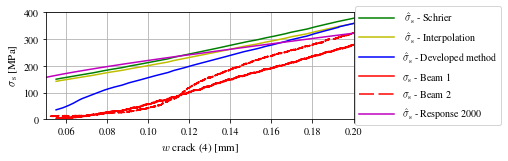

In [27]:
fig5 = plt.figure(figsize=(2*figsize[0],figsize[1]));
plt.plot(datframe_crack_width_1["w"].iloc[nstart_1:nstart_1+npoints_1],sigs_schrier_1,'g',\
         label=r" $\hat{\sigma}_{\mathrm{s}}$ - Schrier");
plt.plot(datframe_crack_width_1["w"].iloc[nstart_1:nstart_1+npoints_1],sigs_inpl_1,'y',\
         label=r" $\hat{\sigma}_{\mathrm{s}}$ - Interpolation");
plt.plot(datframe_crack_width_1["w"].iloc[nstart_1:nstart_1+npoints_1],sigs_new_1,'b',\
         label=r"$\hat{\sigma}_{\mathrm{s}}$ - Developed method");
plt.plot(datframe_crack_width_1["w"].iloc[nstart_1:nstart_1+npoints_1],sigs_meas_1,'r-',markevery=50,\
         label=r"$\sigma_{\mathrm{s}}$ - Beam 1");
plt.plot(datframe_crack_width_2["w"].iloc[nstart_2:nstart_2+npoints_2],sigs_meas_2,'r--',dashes=(10,3),markevery=200,\
        label=r"$\sigma_{\mathrm{s}}$ - Beam 2");
plt.plot(dat_response_2000["w"],dat_response_2000["sigs"],'m',label=r"$\hat{\sigma}_{\mathrm{s}}$ - Response 2000");
dat_response_2000
plt.xlim(0.05,0.2);
plt.ylim(0,400);
plt.xlabel(r"$w$ crack (4) [mm]");
plt.ylabel(r" $\sigma_{\mathrm{s}}$ [MPa]");
plt.grid();
plt.legend(bbox_to_anchor=(1.48,0.5),loc="right",borderaxespad=0,handlelength=3.5);
fig5.savefig(r'C:\Users\20210065\surfdrive\Documents\60_Publications\Synercrete_23\Figures\Export_Python\stress_both_beams.tif',\
                          bbox_inches='tight',dpi=(dpisize));

## 7 - Force - time - crack width $w$ plots

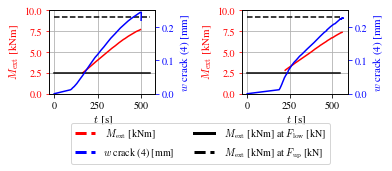

In [28]:
# Function to plot the axis
def two_scales(ax1, time1, time2, data1, data2, c1, c2):
    ax2 = ax1.twinx()
    ax1.plot(time1, data1, color=c1)
    ax1.set_xlabel(r" $t$ [s]")
    ax1.set_ylabel(r" $M_{\mathrm{ext}}$ [kNm]",color='r')
    ax1.tick_params(axis='y', colors='r') ;
    ax1.set_ylim([0,10]);
    ax2.set_ylim([0,0.25]);
    ax2.plot(time2, data2, color=c2)
    ax2.set_ylabel(r'$w$ crack (4) [mm]',color='b')
    ax2.tick_params(axis='y', colors='b') ;
    ax1.grid()
    ax1.plot([0,550],[M_crack_1,M_crack_1],"k-",label="Mext acc Fup");
    ax1.plot([0,550],[Mr/(10**6),Mr/(10**6)],"k--",label="Mext acc Fup")
    return ax1, ax2

# Create axes
fig10, (ax1, ax2) = plt.subplots(1,2, figsize=(2*figsize[0],figsize[1]))
ax1, ax1a = two_scales(ax1, dat_beams["Time_DOFS_1"].iloc[nstart_1:nstart_1+npoints_1],\
                       crack_width_beam_1["Time"], Mext_1/(10**6),crack_width_beam_1["w"], 'r', 'b')
ax2, ax2a = two_scales(ax2, dat_beams["Time_DOFS_2"].iloc[nstart_2:nstart_2+npoints_2],\
                       crack_width_beam_2["Time"], Mext_2/(10**6),crack_width_beam_2["w"], 'r', 'b')

# Change color of each axis
def color_y_axis(ax, color):
    """Color your axes."""
    for t in ax.get_yticklabels():
        t.set_color(color)

# Plot settings
plt.tight_layout();
colors = ['red', 'blue', 'black', 'black'];
line1= Line2D([0], [0], color='red',linewidth=3, linestyle='--');
line2= Line2D([0], [0], color='blue', linewidth=3, linestyle='--');
line3= Line2D([0], [0], color='black', linewidth=3, linestyle='-');
line4= Line2D([0], [0], color='black', linewidth=3, linestyle='--');
labels = [r" $M_{\mathrm{ext}}$ [kNm]", r'$w$ crack (4) [mm]',\
         r" $M_{\mathrm{ext}}$ [kNm] at $F_{\mathrm{low}}$ [kN]",\
         r" $M_{\mathrm{ext}}$ [kNm] at $F_{\mathrm{up}}$ [kN]"];
plt.legend([line1,line2,line3,line4], labels,loc='lower center',bbox_to_anchor=(-0.4,-0.9),ncol=2);
plt.show();
fig10.savefig(r'C:\Users\20210065\surfdrive\Documents\60_Publications\Synercrete_23\Figures\Export_Python\subplots.tif',\
                          bbox_inches='tight',dpi=(dpisize));

## 8 - Evaluate the strains and stresses at the top and bottom of the cross section, respectively

### Beam 1

#### Developed method

In [29]:
# Bending moment at start
print("Bending moment",round(Mext_1[0]/(1e6),3),"kNm");
print("Stress at top",round(eps_c_new_1[0],5),"-");
print("Stress at bottom",round(eps_c_new_1[0]*(h-xc_new_1[0])/xc_new_1[0],5),"-");
print("Height of the cross section",round(xc_new_1[0],3),"mm");
print("\n");
print("Bending moment",round(Mext_1[-1]/(1e6),3),"kNm")
print("Stress at top",round(eps_c_new_1[-1],5),"-");
print("Stress at bottom",round(eps_c_new_1[-1]*(h-xc_new_1[-1])/xc_new_1[-1],5),"-");
print("Height of the cross section",round(xc_new_1[-1],3),"mm");
print("Stress in reinforcement at a crack",sigs_new_1[-1])

Bending moment 2.505 kNm
Stress at top 0.00023 -
Stress at bottom 0.00028 -
Height of the cross section 67.207 mm


Bending moment 7.688 kNm
Stress at top 0.00114 -
Stress at bottom 0.00307 -
Height of the cross section 40.664 mm
Stress in reinforcement at a crack 446.1607396359682


#### v.d. Schrier

In [30]:
print("Bending moment",round(Mext_1[0]/(1e6),3),"kNm")
print("Stress at top",round(eps_c_schrier_1[0],5),"-");
print("Stress at bottom",round(eps_c_schrier_1[0]*(h-xc_schrier_1[0])/xc_schrier_1[0],5),"-");
print("Height of the cross section",round(xc_schrier_1[0],3),"mm");
print("\n");
print("Bending moment",round(Mext_1[-1]/(1e6),3),"kNm")
print("Stress at top",round(eps_c_schrier_1[-1],5),"-");
print("Stress at bottom",round(eps_c_schrier_1[-1]*(h-xc_schrier_1[-1])/xc_schrier_1[-1],5),"-");
print("Height of the cross section",round(xc_schrier_1[-1],3),"mm");

Bending moment 2.505 kNm
Stress at top 0.00039 -
Stress at bottom 0.00103 -
Height of the cross section 40.743 mm


Bending moment 7.688 kNm
Stress at top 0.00118 -
Stress at bottom 0.00317 -
Height of the cross section 40.743 mm


#### Interpolation method

In [31]:
print("Bending moment",round(Mext_1[0]/(1e6),3),"kNm")
print("Stress at top",round(eps_c_inpl_1[0],5),"-");
print("Stress at bottom",round(eps_c_inpl_1[0]*(h-xc_inpl_1[0])/xc_inpl_1[0],5),"-");
print("Height of the cross section",round(xc_inpl_1[0],3),"mm");
print("\n");
print("Bending moment",round(Mext_1[-1]/(1e6),3),"kNm")
print("Stress at top",round(eps_c_inpl_1[-1],5),"-");
print("Stress at bottom",round(eps_c_inpl_1[-1]*(h-xc_inpl_1[-1])/xc_inpl_1[-1],5),"-");
print("Height of the cross section",round(xc_inpl_1[-1],3),"mm");

Bending moment 2.505 kNm
Stress at top 0.00015 -
Stress at bottom 0.00097 -
Height of the cross section 19.753 mm


Bending moment 7.688 kNm
Stress at top 0.00045 -
Stress at bottom 0.00299 -
Height of the cross section 19.753 mm


### Beam 2

#### Developed method

In [32]:
# Bending moment at start
print("Bending moment",round(Mext_2[0]/(1e6),3),"kNm");
print("Stress at top",round(eps_c_new_2[0],5),"-");
print("Stress at bottom",round(eps_c_new_2[0]*(h-xc_new_2[0])/xc_new_2[0],5),"-");
print("Height of the cross section",round(xc_new_2[0],3),"mm");
print("\n");
print("Bending moment",round(Mext_2[-1]/(1e6),3),"kNm")
print("Stress at top",round(eps_c_new_2[-1],5),"-");
print("Stress at bottom",round(eps_c_new_2[-1]*(h-xc_new_2[-1])/xc_new_2[-1],5),"-");
print("Height of the cross section",round(xc_new_2[-1],3),"mm");

Bending moment 2.811 kNm
Stress at top 0.00031 -
Stress at bottom 0.00048 -
Height of the cross section 58.545 mm


Bending moment 7.357 kNm
Stress at top 0.00109 -
Stress at bottom 0.00291 -
Height of the cross section 40.94 mm


#### v.d. Schrier

In [33]:
print("Bending moment",round(Mext_2[0]/(1e6),3),"kNm")
print("Stress at top",round(eps_c_schrier_2[0],5),"-");
print("Stress at bottom",round(eps_c_schrier_2[0]*(h-xc_schrier_2[0])/xc_schrier_2[0],5),"-");
print("Height of the cross section",round(xc_schrier_2[0],3),"mm");
print("\n");
print("Bending moment",round(Mext_2[-1]/(1e6),3),"kNm")
print("Stress at top",round(eps_c_schrier_2[-1],5),"-");
print("Stress at bottom",round(eps_c_schrier_2[-1]*(h-xc_schrier_2[-1])/xc_schrier_2[-1],5),"-");
print("Height of the cross section",round(xc_schrier_2[-1],3),"mm");

Bending moment 2.811 kNm
Stress at top 0.00043 -
Stress at bottom 0.00116 -
Height of the cross section 40.743 mm


Bending moment 7.357 kNm
Stress at top 0.00113 -
Stress at bottom 0.00303 -
Height of the cross section 40.743 mm


#### Interpolation method

In [34]:
print("Bending moment",round(Mext_2[0]/(1e6),3),"kNm")
print("Stress at top",round(eps_c_inpl_2[0],5),"-");
print("Stress at bottom",round(eps_c_inpl_2[0]*(h-xc_inpl_2[0])/xc_inpl_2[0],5),"-");
print("Height of the cross section",round(xc_inpl_2[0],3),"mm");
print("\n");
print("Bending moment",round(Mext_2[-1]/(1e6),3),"kNm")
print("Stress at top",round(eps_c_inpl_2[-1],5),"-");
print("Stress at bottom",round(eps_c_inpl_2[-1]*(h-xc_inpl_2[-1])/xc_inpl_2[-1],5),"-");
print("Height of the cross section",round(xc_inpl_2[-1],3),"mm");

Bending moment 2.811 kNm
Stress at top 0.00017 -
Stress at bottom 0.00109 -
Height of the cross section 19.753 mm


Bending moment 7.357 kNm
Stress at top 0.00043 -
Stress at bottom 0.00286 -
Height of the cross section 19.753 mm
